In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic 
import scipy
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline


# Kings County Real Estate Predictions

In [5]:
data = pd.read_csv('../Phase-2-Project/Data/kc_house_data_train.csv')
data.drop(columns = 'Unnamed: 0', inplace = True)
data.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


## Exploratory Data Analysis

In [19]:
data.describe()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_log
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,...,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,...,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,13.048109
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,...,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583,0.526865
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,...,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,11.225243
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,...,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,12.679196
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,...,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,13.017003
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,...,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,13.377006
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,15.856731


In [29]:
seatle_map = gpd.read_file('../Phase-2-Project/Data/kc_tract_10.shp')
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(data['long'], data['lat'])]
geo_df = gpd.GeoDataFrame(data, 
                          crs = crs, 
                          geometry = geometry)

geo_df['price_log'] = np.log(geo_df['price'])
fig, ax = plt.subplots(figsize = (15,15))
seatle_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'price_log', ax=ax, cmap = 'rainbow', legend = True, legend_kwds={'shrink': 0.3})

ax.set_title('Kings County Logged Price Heat Map')
plt.savefig('Property Price Heat Map')

DriverError: Unable to open ../Phase-2-Project/Data/kc_tract_10.shx or ../Phase-2-Project/Data/kc_tract_10.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

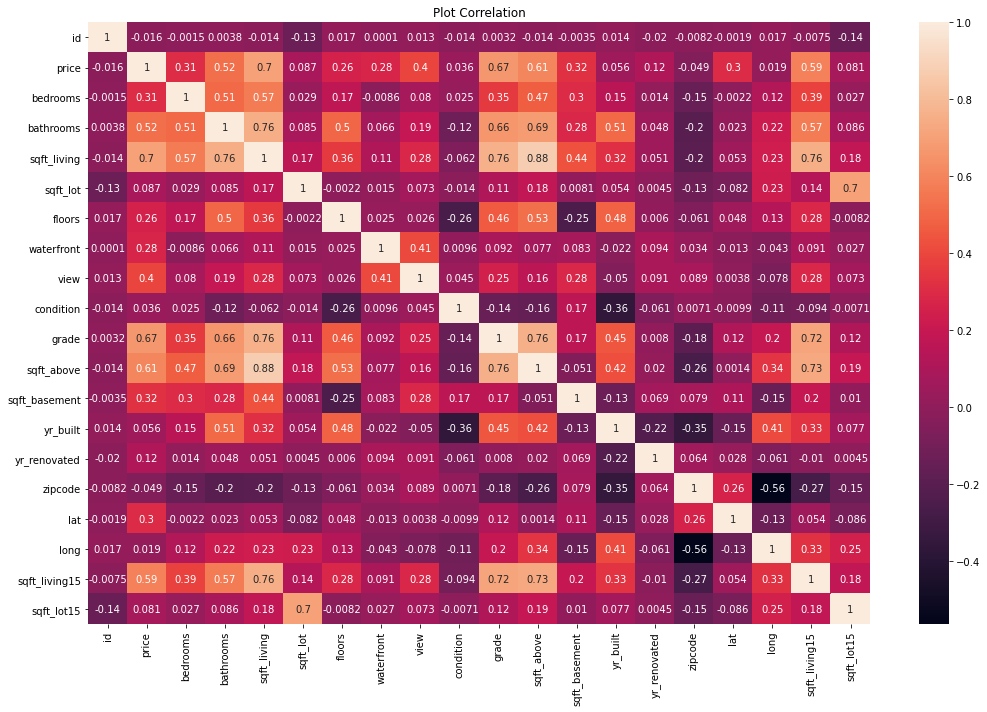

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.title('Plot Correlation')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

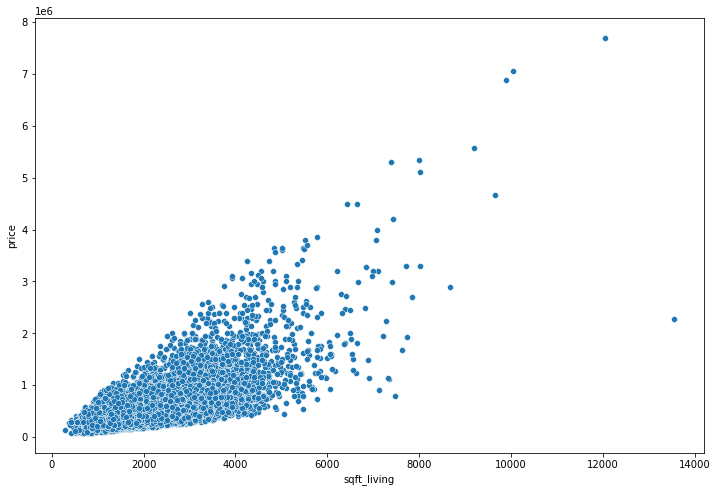

In [11]:
fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x = data.sqft_living, y = data.price)

Text(0.5, 1.0, 'Price x Year House Built')

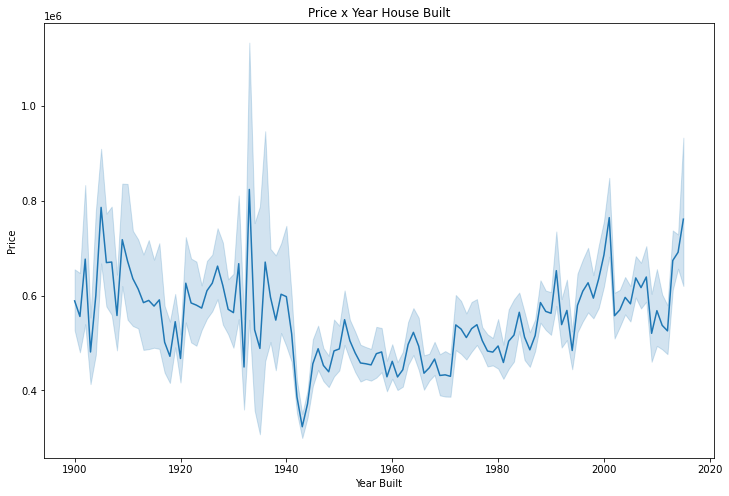

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = data['yr_built'], y = data['price'])
ax.set_xlabel('Year Built')
ax.set_ylabel('Price')
ax.set_title('Price x Year House Built')

Text(0.5, 1.0, 'Price x Zipcode')

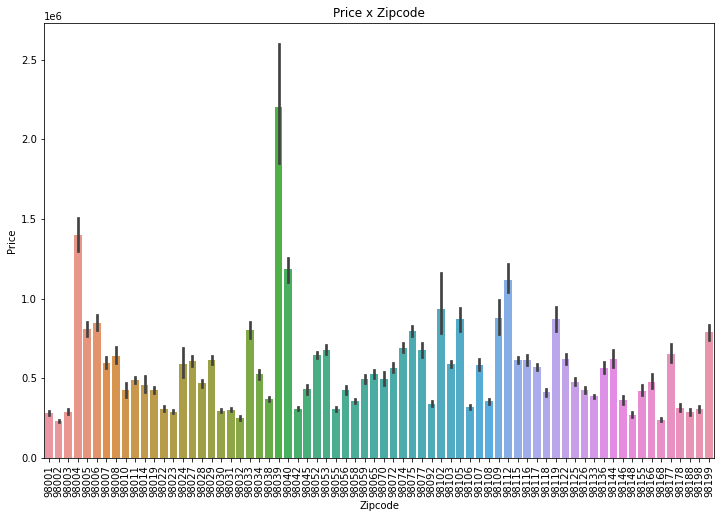

In [14]:
fig, ax = plt.subplots(figsize = (12,8))
zipcode_graph = sns.barplot(x = data.zipcode, y = data.price)
plt.xticks(rotation = 90)
ax.set_xlabel('Zipcode')
ax.set_ylabel('Price')
ax.set_title('Price x Zipcode')

Text(0.5, 1.0, 'Price x Grade')

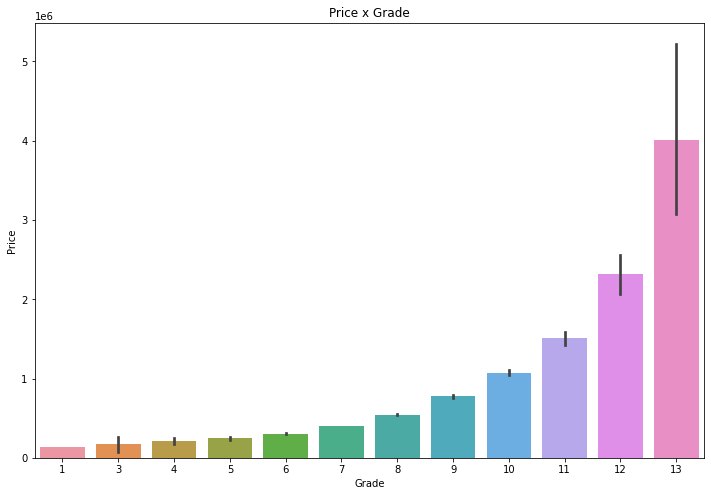

In [15]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(x = data.grade, y = data.price)
ax.set_xlabel('Grade')
ax.set_ylabel('Price')
ax.set_title('Price x Grade')


## Data Cleaning

There was no missing data in our dataset. Most data preperation focused on cleaning outliers and engineering additional features if needed. Below is how we dealt with outliers in the 'Sqft Living', 'Bedrooms' and 'Bathrooms' columns. 

Text(0.5, 1.0, 'Bathrooms')

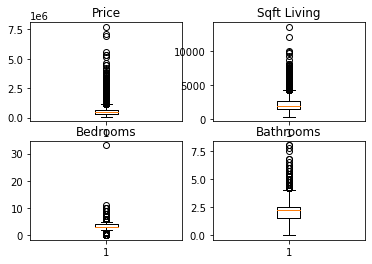

In [24]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].boxplot(data.price,)
axs[0, 0].set_title('Price')
axs[0, 1].boxplot(data.sqft_living)
axs[0, 1].set_title('Sqft Living')
axs[1, 0].boxplot(data.bedrooms,)
axs[1, 0].set_title('Bedrooms')
axs[1, 1].boxplot(data.bathrooms,)
axs[1, 1].set_title('Bathrooms')

Outliers in the data set were capped at 5 standard deviations away from the mean.

In [25]:
above_5std_living = data.sqft_living.mean()+(5*data.sqft_living.std())
above_5std_bathrooms = data.bathrooms.mean()+(5*data.bathrooms.std())
above_5std_bedrooms = data.bedrooms.mean()+(5*data.bedrooms.std())

data['sqft_living'] = np.where(data['sqft_living']>above_5std_living, above_5std_living, data['sqft_living'])
data['bathrooms'] = np.where(data['bathrooms']>above_5std_bathrooms, 6, data['bathrooms'])
data['bedrooms'] = np.where(data['bedrooms']>above_5std_bedrooms, 8, data['bedrooms'])
data['bathrooms'] = np.where(data['bathrooms']==0, .5, data['bathrooms'])
data['bedrooms'] = np.where(data['bedrooms']==0, .5, data['bedrooms'])

Text(0.5, 1.0, 'Bathrooms')

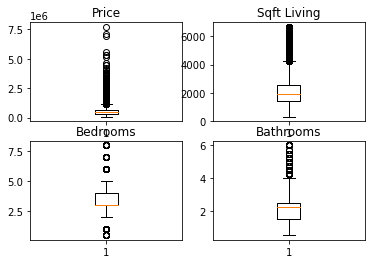

In [26]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].boxplot(data.price,)
axs[0, 0].set_title('Price')
axs[0, 1].boxplot(data.sqft_living,)
axs[0, 1].set_title('Sqft Living')
axs[1, 0].boxplot(data.bedrooms,)
axs[1, 0].set_title('Bedrooms')
axs[1, 1].boxplot(data.bathrooms,)
axs[1, 1].set_title('Bathrooms')